In [1]:
import numpy as np
import random
from numpy import array
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
import calendar;
import time;
from scipy import stats
from datetime import date, datetime
import arviz as az
#plt.style.use('science')
az.style.use(["science", "grid"])
%config InlineBackend.figure_format = 'retina'

In [2]:
##
def calculateRMSE(a_x_true, a_x_pred, a_step = 1):
    rmse = []
    for i in range(0, a_x_true.shape[0], a_step):
        x_true = a_x_true[i,:,0]
        x_pred = a_x_pred[i,:,0]
        temp = np.sqrt(mean_squared_error(x_true, x_pred))
        rmse = rmse + [temp]
    return rmse

def calculateMetrics(a_x_true, a_x_pred, a_step = 1):
    rmse = []
    nrmse = []
    for i in range(0, a_x_true.shape[0], a_step):
        x_true = a_x_true[i,:,0]
        x_pred = a_x_pred[i,:,0]
        temp = np.sqrt(mean_squared_error(x_true, x_pred))
        rmse = rmse + [temp]
        iqr = np.subtract(*np.percentile(x_true, [75, 25]))
        #print(iqr)
        nrmse = nrmse + [temp / ((np.max(x_true)-np.min(x_true)))]
        #nrmse = nrmse + [temp / iqr]
    print(stats.describe(nrmse))
    print("NRMSE", "Q1", np.quantile(nrmse,0.25), "Q2", np.quantile(nrmse, 0.5), "Q3", np.quantile(nrmse,0.75))
    print("\n")
    print(stats.describe(rmse))
    print("RMSE", "Q1", np.quantile(rmse,0.25), "Q2", np.quantile(rmse, 0.5), "Q3", np.quantile(rmse,0.75))
    plt.bar(range(1,len(nrmse)+1),rmse)
    plt.title("Average RMSE per 24 Hours Interval")
    plt.ylabel("RMSE")
    plt.xlabel("24 Hour Intervals")
    plt.show()

def rescale(a_data, a_scaler):
    samples = []
    for i in range(0, a_data.shape[0]):
        temp = a_data[i,:,0]
        temp_scaled = a_scaler.inverse_transform(temp.reshape(WINDOW_SIZE,-1))
        
        samples = samples + [temp_scaled]
    return np.stack([i for i in samples],axis=0)
    
def plotErrors(a_train, a_validation, a_metric="mae"):
    plt.plot(a_train[::], label='train %s'%(a_metric)), 
    plt.plot(a_validation[::], label='validation %s'%(a_metric))
    plt.ylabel(a_metric)
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy (%s)'%(a_metric))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

def getFeatureString():
    features_d0 = ""
    features_d1 = ""
    
    for f in d0:
        features_d0 = features_d0 + "--%s"%(f)
        
    for f in d1:
        features_d1 = features_d1 + "--%s"%(f)
        
    features_string = "_Fd0%s_Fd1%s_"%(features_d0,features_d1)
    #print(features_string)
    return features_string.replace("*", "x")

def saveModel(a_prefix):
    features_d0 = ""
    features_d1 = ""
    
    for f in d0:
        features_d0 = features_d0 + "--%s"%(f)
        
    for f in d1:
        features_d1 = features_d1 + "--%s"%(f)
        
    ts = calendar.timegm(time.gmtime())
    
    do = str(dropout)
        
    file_name = "Net-%s%s_Units-%d_BS-%s_Epc-%d_Do-%s_Wo-%d_W1-%d_Fd0%s_Fd1%s_Tr-%s--%s_CD-%s_%d.h5"%(a_prefix, net, n_units, batch_size, epochs, 
                                                                       do,WINDOW_SIZE*w0, WINDOW_SIZE*w1, features_d0, features_d1, 
                                                                    train_start, train_end, str(cleanData), ts)
    
    file_name = file_name.replace("*", "x")
    model.save("%s"%file_name)
    print(file_name)  
    
    

def _add_holidays(df):
    """
    Add a binary variable to the dataset that takes value: 1 if the day is a holiday, 0 otherwise.
    Main holidays for the New England area are considered.
    :param df: the datafrme
    :return: the agumented dtaframe
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        idx = []
        idx.extend(df[df.day == 1][df.month == 1].index.tolist())  # new year's eve
        idx.extend(df[df.day == 4][df.month == 7].index.tolist())  # independence day
        idx.extend(df[df.day == 11][df.month == 11].index.tolist())  # veternas day
        idx.extend(df[df.day == 25][df.month == 12].index.tolist())  # christams
        df.loc[idx, 'holiday'] = 1
        return df
    
    
def transform(X, scaler=None, scaler_type=None):
    """
    Apply standard scaling to the input variables
    :param X: the data
    :param scaler: the scaler to use, None if StandardScaler has to be used
    :return:
        scaler used
        X transformed using scaler
    """
    if scaler is None:
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()
        scaler.fit(X)
    return scaler, scaler.transform(X)


def inverse_transform(X, scaler, trend=None):
    """
    :param X: the data
    :param scaler: the scaler that have been used for transforming X
    :param trend: the trebd values that has been removed from X. None if no detrending has been used.
        It has to be the same dim. as X.
    :return:
        X with trend adds back and de-standardized
    """
    X = X.astype(np.float32)
    X = scaler.inverse_transform(X)
    try:
        X += trend
    except TypeError as e:
        print(str(e))
    except Exception as e:
        print('General error (not a TypeError) while adding back time series trend. \n {}'.format(str(e)))
    return X


# Load data

In [3]:
import pytz
from pytz import timezone
def loadData(a_path, a_cols, a_rename = None, a_idx_field="timestamp", a_period="1T", a_timezone = None):
    data = pd.DataFrame()
    for path in a_path:
        data_temp = pd.read_csv(path, usecols = a_cols)
        data  = pd.concat([data, data_temp], ignore_index=True)
    
    
    data[a_idx_field] = pd.to_datetime(data[a_idx_field], utc=True)

    
    if a_rename != None:
        data.rename(columns = a_rename, inplace=True)
    data.set_index(a_idx_field, inplace=True)
    #data = data.interpolate(method="time")
    if a_timezone != None:
        data.index = data.index.tz_convert(a_timezone)
    data = data.resample(a_period).mean()

    return data

In [8]:
## LOAD AND SPLIT DATA 30T

def load_dataset():
    """
    Load an already cleaned version of the dataset
    """
    load = loadData(['../data/Load_1M_2019.csv', '../data/Load_1M_2020.csv'], 
                a_cols = ["timestamp", "measure_cons"], a_rename={"measure_cons":"Load"}, a_period="30T", 
                a_timezone = "Atlantic/Madeira")

    radiation = loadData(['../data/Solcast_PT30M_2019.csv', '../data/Solcast_PT30M_2020.csv'], 
               a_cols = ["PeriodStart", "Ghi", "Dhi", "AirTemp", "CloudOpacity"], a_idx_field="PeriodStart", a_period="30T", 
               a_timezone = "Atlantic/Madeira")
    
    return load, radiation

def add_exogenous_variables(df, one_hot=True):
    """
    Augument the dataframe with exogenous features (date/time feature + holiday feature).
    The feature's values can be kept as they are or they can be one hot encoded
    :param df: the dataframe
    :param one_hot: if True, one hot encode all the features.
    :return: two matrix of exogenous features,
     the first for temperatures only the second one contains all the other variables.
    """
    data['DAYOFWEEK'] = ((pd.DatetimeIndex(data.index).dayofweek))
    data['DAYOFYEAR'] = ((pd.DatetimeIndex(data.index).dayofyear))
    data['YEAR'] = ((pd.DatetimeIndex(data.index).year))
    data['MONTH'] = ((pd.DatetimeIndex(data.index).month))
    data['DAY'] = ((pd.DatetimeIndex(data.index).day))
    data['HOUR'] = ((pd.DatetimeIndex(data.index).hour))
   
    if one_hot:
        ex_feat = pd.get_dummies(df, columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'DAYOFWEEK', 'DAYOFYEAR'])
        return ex_feat
    else:
        return df.values






In [19]:
import sys
import warnings
sys.path.append("../src/")
from utils.prepare_loadforecast_data import *
SAMPLES_PER_DAY = 48
TARGET = 'Load'
load, radiation = load_dataset()
radiation=radiation['2019-02-01':'2020-02-14']
load = load['2019-02-01':'2020-02-14']

In [20]:
print(f"Total data sample: {load.shape[0]}")
print(f"Missing data sample: {load.isnull().sum()[0]}")
print(f" percentage of Missing data sample: {load.isnull().sum()[0]/len(load)}")

Total data sample: 18146
Missing data sample: 16712
 percentage of Missing data sample: 0.9209743194092362


In [27]:
data = pd.merge(radiation, load, how = 'outer', left_index = True, right_index = True)
data.sort_index(inplace=True)
data.dropna(inplace = True)

print(f"Total data sample: {data.shape[0]}")
print(f"Missing data sample: {data.isnull().sum()[0]}")
print(f" percentage of data loss : {1- (data.shape[0]/len(load))}")

Total data sample: 1434
Missing data sample: 0
 percentage of data loss : 0.9209743194092362


In [28]:
data.head()

,AirTemp,CloudOpacity,Dhi,Ghi,Load
2019-02-01 12:30:00+00:00,17.9,2.8,177,624,7984.680000
2019-02-01 13:00:00+00:00,17.7,4.4,201,627,9465.482609
2019-02-01 13:30:00+00:00,17.4,0.5,148,650,14183.436667
2019-02-01 14:00:00+00:00,17.2,1.0,150,629,12686.746667
2019-02-01 14:30:00+00:00,17.0,0.0,129,602,6689.906667


In [29]:
#combine radiation and load data
data["LoadxGhi"] = data["Load"] * data["Ghi"]
data["P-LoadxGhi"] = data["Load"] - data["LoadxGhi"]
data["P-Ghi"] = data["Load"] - data["Ghi"]

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
targets = data[[TARGET]].values
features = data.drop(labels=TARGET, axis=1).values
scaler = StandardScaler()
X = scaler.fit_transform(features)
print(X.shape)
targets=np.where(targets<0, 0, targets)
y = np.log1p(targets)
print(y.shape)
scaler = MinMaxScaler()
time_features=add_exogenous_variables(data, one_hot=False)
time_features = scaler.fit_transform(time_features)
X = np.concatenate([X, time_features], 1)
print(X.shape)
XY = np.concatenate([y, X], 1)
print(XY.shape)

(1434, 7)
(1434, 1)
(1434, 21)
(1434, 22)


In [31]:
window_size, horizon = int(48*2), 48

In [32]:
from utils.prepare_loadforecast_data import *

In [33]:
X, y = get_rnn_inputs(XY,
                                      window_size,
                                       horizon,
                                      shuffle=False,
                                      multivariate_output=False)

100%|██████████| 1/1 [00:00<00:00, 338.09it/s]


In [34]:
size =int(0.75*(len(X)))
X_train, X_val = X[:size], X[size:]
y_train, y_val = y[:size], y[size:]

In [52]:
print(X_train.shape)
print(y_train.shape)

(968, 96, 22)
(968, 48)


In [37]:
import torch 
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  inputs, targets,   seq_len=10):
        if inputs.ndim ==1:
            inputs = inputs[:, None]
        self.inputs = inputs
        self.targets = targets
        self.len = self.inputs.shape[0] 
       
    def __len__(self):
        'Denotes the total number of samples'
        return self.len
    
    def __getitem__(self, index):
        inputs, target = self.inputs[index], self.targets[index]
        return torch.tensor(inputs).float(), torch.tensor(target).float().squeeze(-1)
    

In [38]:
tra_data = Dataset(X_train, y_train)
val_data = Dataset(X_val, y_val)
tra_loader=torch.utils.data.DataLoader(tra_data,batch_size=64,
                                            shuffle=True,  drop_last=False)
val_loader=torch.utils.data.DataLoader(val_data,batch_size=64,
                                            shuffle=False,  drop_last=False)

In [39]:
from net.Seq2fpq import FPQForecast, model_pil

In [40]:
network = FPQForecast(n_channels=X.shape[-1],
                      emb_size=64, 
                      latent_size=128, 
                      out_size=48, 
                      hidden_size=128, 
                      context_size=96, 
                      num_layers=2)

In [41]:
from pathlib import Path
results = Path("../results/")
logs = Path("../logs/")
checkpoints = Path("../checkpoints/forecasting_lucas/")
logs.mkdir(parents=True, exist_ok=True)
results.mkdir(parents=True, exist_ok=True)
checkpoints.mkdir(parents=True, exist_ok=True)

In [42]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger


checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoints, 
                                                           monitor='val_mae', 
                                                           mode="min", save_top_k=1)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=50, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger  = TensorBoardLogger(logs,name = "forecast_v2", version = 0)
        
trainer = pl.Trainer(
                    logger = logger,
                    checkpoint_callback=checkpoint_callback,
                    max_epochs=50,
                    gpus=-1 if torch.cuda.is_available() else None,
                    callbacks=[lr_logger, early_stop_callback],
                    weights_summary="top"
                     )
model   = model_pil(network)
trainer.fit(model, tra_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type        | Params
--------------------------------------
0 | model | FPQForecast | 1.8 M 
--------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.125     Total estimated model params size (MB)
/Users/anthonyfaustine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/anthonyfaustine/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [43]:
from net.utils import get_latest_checkpoint
from tqdm import tqdm_notebook as tqdm
dataloader=val_loader
path_best_model = get_latest_checkpoint(checkpoints)
checkpoint      = torch.load(path_best_model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
batch_size   = dataloader.batchsize if hasattr(dataloader, 'len') else dataloader.batch_size
outputs = []
num_batches = len(dataloader)
values = range(num_batches)
with tqdm(total=len(values), file=sys.stdout) as pbar:
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            logs = model.test_step(batch, batch_idx, model.model)
            outputs.append(logs)
            del  batch
            pbar.set_description('processed: %d' % (1 + batch_idx))
            pbar.update(1)
        pbar.close()
         
    results = model.test_epoch_end(outputs)      
        
        

<ipython-input-43-2c7965ef755a>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(values), file=sys.stdout) as pbar:


In [44]:
pred = results["pred"].data.expm1().clamp(min=0).numpy()
q_pred = results["q_pred"].data.expm1().clamp(min=0).numpy()
true =results["true"].data.expm1().clamp(min=0).numpy()

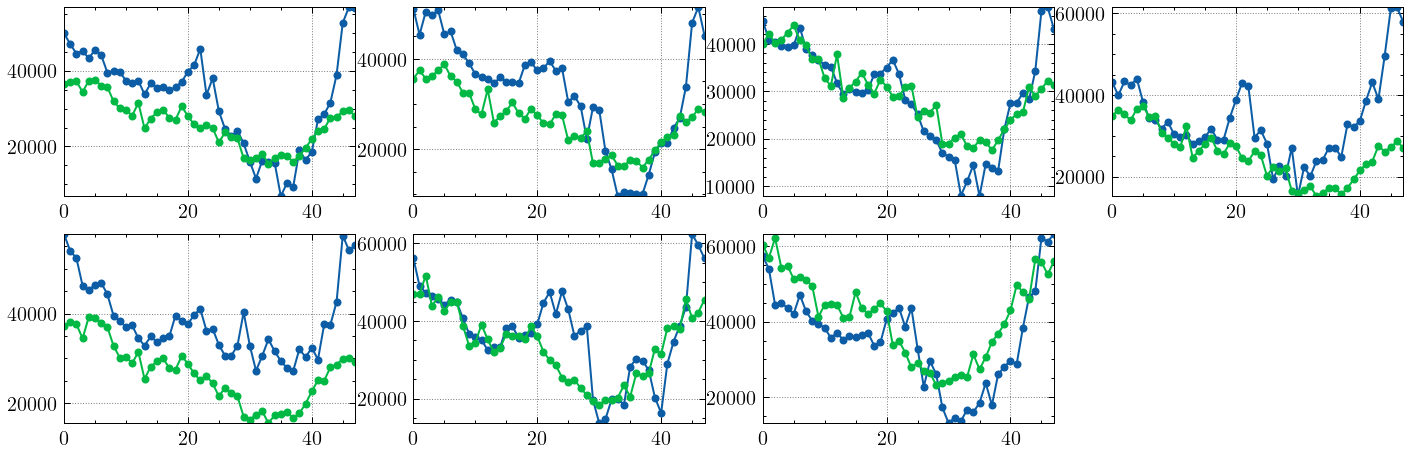

In [49]:
horizon = 48
figure = plt.figure(figsize=(12,8))
max_els = round(pred.shape[0]/horizon)
for i in range(max_els):
    day = int(horizon*i)
    ax1=plt.subplot(4, 4, i+1)
    #print(day)

    plt.plot(true[day, ],'.-', label="True")
    plt.plot(pred[day, :],'.-', label="Pred")
    #plt.fill_between(np.arange(len(q_pred[day][0,:])), q_pred[day][0,:].flatten(),q_pred[day][-1,:].flatten(), color="darkorange", alpha=0.6)
    ax = plt.gca()
    ax.autoscale(tight=True)

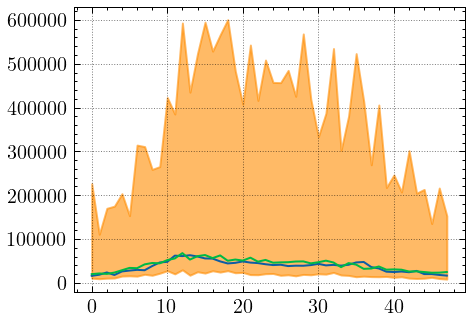

In [50]:
day=-1
plt.plot(true[day])
plt.plot(pred[day])
plt.fill_between(np.arange(len(q_pred[day][0,:])), q_pred[day][0,:].flatten(),q_pred[day][-1,:].flatten(), color="darkorange", alpha=0.6)
plt.savefig("prediction.pdf")